In [1]:
import openmc

! rm -f *.h5 *.xml

In [2]:
# Fuel Material
uo2 = openmc.Material(1, "uo2")
uo2.add_element('U', 1.0, enrichment=4.0)
uo2.add_element('O', 2.0)
uo2.set_density('g/cm3', 10.7)

In [3]:
# Cladding Material
zirconium = openmc.Material(2, "zirconium")
zirconium.add_element('Zr', 1.0)
zirconium.set_density('g/cm3', 6.6)

In [4]:
# Water/Moderator Material
water = openmc.Material(3, 'h2o')
water.add_element('H', 2.0)
water.add_element('O', 1.0)
water.set_density('g/cm3', 1.0)
water.add_s_alpha_beta('c_H_in_H2O')

In [5]:
# Control Rod Material
boroncarbide = openmc.Material(4, "b4c")
boroncarbide.add_element('B', 4.0)
boroncarbide.add_element('C', 1.0)
boroncarbide.set_density('g/cm3', 2.52)

In [6]:
# Reflector Material
beryllium = openmc.Material(5, 'Be')
beryllium.add_element('Be', 1.0)
beryllium.set_density('g/cm3', 1.85)

In [7]:
mats = openmc.Materials([uo2, zirconium, water, boroncarbide, beryllium])
mats.export_to_xml()
!cat materials.xml

<?xml version='1.0' encoding='utf-8'?>
<materials>
    <material id="1" name="uo2">
        <density units="g/cm3" value="10.7" />
        <nuclide ao="0.0003253143269071167" name="U234" />
        <nuclide ao="0.0404907684840514" name="U235" />
        <nuclide ao="0.9591839171890415" name="U238" />
        <nuclide ao="1.999242" name="O16" />
        <nuclide ao="0.000758" name="O17" />
    </material>
    <material id="2" name="zirconium">
        <density units="g/cm3" value="6.6" />
        <nuclide ao="0.5145" name="Zr90" />
        <nuclide ao="0.1122" name="Zr91" />
        <nuclide ao="0.1715" name="Zr92" />
        <nuclide ao="0.1738" name="Zr94" />
        <nuclide ao="0.028" name="Zr96" />
    </material>
    <material id="3" name="h2o">
        <density units="g/cm3" value="1.0" />
        <nuclide ao="1.99968852" name="H1" />
        <nuclide ao="0.00031148" name="H2" />
        <nuclide ao="0.999621" name="O16" />
        <nuclide ao="0.000379" name="O17" />
        <sa

In [8]:
R_fuel = 0.96/2
R_inner_clad = 0.98/2
R_outer_clad = 1.12/2
pitch = 1.4

In [9]:
#Fuel Pin Surfaces
fuel_or = openmc.ZCylinder(R=R_fuel)
fuel_clad_ir = openmc.ZCylinder(R=R_inner_clad)
fuel_clad_or = openmc.ZCylinder(R=R_outer_clad)
fuel_box_surface = openmc.get_rectangular_prism(width=pitch, height=pitch)

#Fuel Pin Region
fuel_region = -fuel_or
fuel_gap_region = +fuel_or & -fuel_clad_ir
fuel_clad_region = +fuel_clad_ir & -fuel_clad_or
fuel_water_region = +fuel_clad_or & fuel_box_surface

#Fuel Pin Cell
fuel_lattice = openmc.Cell(fill=uo2, region=fuel_region)
fuel_gap_lattice = openmc.Cell(region=fuel_gap_region)
fuel_clad_lattice = openmc.Cell(fill=zirconium, region=fuel_clad_region)
fuel_moderator_lattice = openmc.Cell(fill=water, region=fuel_water_region)

#print(fuel_lattice)
#print(fuel_gap_lattice)
#print(fuel_clad_lattice)
#print(fuel_moderator_lattice)

#Fuel Pin Universe
fuel_uni = openmc.Universe(cells=(fuel_lattice, fuel_gap_lattice, fuel_clad_lattice, fuel_moderator_lattice))
#print(fuel_uni)

In [10]:
#Control Pin Surfaces 
control_or = openmc.ZCylinder(R=R_fuel)
control_clad_ir = openmc.ZCylinder(R=R_inner_clad)
control_clad_or = openmc.ZCylinder(R=R_outer_clad)
control_box_surface = openmc.get_rectangular_prism(width=pitch, height=pitch)

#Control Pin Region 
control_region = -control_or
control_gap_region = +control_or & -control_clad_ir
control_clad_region = +control_clad_ir & -control_clad_or
control_water_region = +control_clad_or & control_box_surface

#Control Pin Cell 
control_lattice = openmc.Cell(fill=boroncarbide, region=control_region)
control_gap_lattice = openmc.Cell(region=control_gap_region)
control_clad_lattice = openmc.Cell(fill=zirconium, region=control_clad_region)
control_moderator_lattice = openmc.Cell(fill=water, region=control_water_region)


#print(control_lattice)
#print(control_gap_lattice)
#print(control_clad_lattice)
#print(control_moderator_lattice)

#Control Pin Universe
control_universe = openmc.Universe(cells=(control_lattice, control_gap_lattice, control_clad_lattice, control_moderator_lattice))

#print(control_universe)

In [11]:
#Define the Lattice
lat = openmc.RectLattice()
lat.pitch = [pitch, pitch]
lat.lower_left = (-(17*pitch/2), -(17*pitch/2))

In [12]:
#Creating array indices for control rod locations in latice (Lower Left is 0,0)
import numpy as np
template_x = np.array([5, 8, 11, 3, 13, 2, 5, 8, 11, 14, 2, 5, 8, 
                       11, 14, 2, 5, 8, 11, 14, 3, 13, 5, 8, 11])
template_y = np.array([2, 2, 2, 3, 3, 5, 5, 5, 5, 5, 8, 8, 8, 8, 
                       8, 11, 11, 11, 11, 11, 13, 13, 14, 14, 14])

In [13]:
#Add Universes to Lattice
lat.universes = np.tile(fuel_uni, (17, 17)) #Creates a 17x17 tile filled with the fuel universe
lat.universes[template_x, template_y] = control_universe #Set control rod universe to template locations
#print(lat.universes)

In [14]:
#Define Cell for Lattice as a Single Unit (Region of entire lattice)
lattice_region = openmc.get_rectangular_prism(width=17*pitch, height=17*pitch)

root_cell = openmc.Cell(fill=lat, region=lattice_region)
#print(root_cell)

In [15]:
#Definining Universe
root_uni = openmc.Universe(name="root universe")
root_uni.add_cell(root_cell)
#print(root_uni)

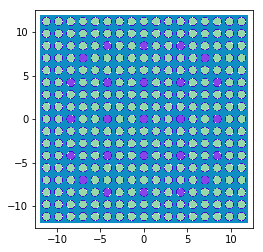

In [16]:
root_uni.plot(width=(25.0, 25.0), color_by = 'material')

In [17]:
water_left_inner = openmc.XPlane(x0=-(17*pitch/2))
water_right_inner = openmc.XPlane(x0=(17*pitch/2))
water_bottom_inner = openmc.YPlane(y0=-(17*pitch/2))
water_top_inner = openmc.YPlane(y0=(17*pitch/2))

In [18]:
water_region = +water_left_inner & -water_right_inner & +water_bottom_inner & -water_top_inner
water_cell = openmc.Cell(fill=water, region=water_region)
water_universe = openmc.Universe(name='water_universe')
water_universe.add_cell(water_cell)
#water_universe.plot(width=(25.0, 25.0), color_by = 'material')

In [19]:
#reflector_left_inner = openmc.XPlane(x0=-(17*pitch/2))
#reflector_right_inner = openmc.XPlane(x0=(17*pitch/2))
#reflector_bottom_inner = openmc.YPlane(y0=-(17*pitch/2))
#reflector_top_inner = openmc.YPlane(y0=(17*pitch/2))

In [20]:
#reflector_region = +reflector_left_inner & -reflector_right_inner & +reflector_bottom_inner & -reflector_top_inner
#reflector_cell = openmc.Cell(fill=carbon, region=reflector_region)
#reflector_universe = openmc.Universe(name='reflector_universe')
#reflector_universe.add_cell(reflector_cell)
#reflector_universe.plot(width=(25.0, 25.0), color_by = 'material')

In [21]:
lat2 = openmc.RectLattice()
lat2.pitch = [17*pitch, 17*pitch]
lat2.lower_left = (-(10*17*pitch/2), -(10*17*pitch/2))

fuel_template_x = np.array([0, 1, 2, 3, 4, 5, 6, 7, 
                            0, 1, 2, 3, 4, 5, 6, 7, 
                            0, 1, 2, 3, 4, 5, 6, 7, 
                            0, 1, 2, 3, 4, 5, 6, 7, 
                            0, 1, 2, 3, 4, 5, 6, 
                            0, 1, 2, 3, 4, 5, 6, 
                            0, 1, 2, 3, 4, 5, 
                            0, 1, 2, 3])
fuel_template_y = np.array([0, 0, 0, 0, 0, 0, 0, 0, 
                            1, 1, 1, 1, 1, 1, 1, 1, 
                            2, 2, 2, 2, 2, 2, 2, 2, 
                            3, 3, 3, 3, 3, 3, 3, 3, 
                            4, 4, 4, 4, 4, 4, 4, 
                            5, 5, 5, 5, 5, 5, 5, 
                            6, 6, 6, 6, 6, 6, 
                            7, 7, 7, 7])

water_template_x = np.array([0, 1, 2, 3, 4, 
                             4, 5, 6, 
                             6, 7, 
                             7, 
                             7, 8, 
                             8, 
                             8, 
                             8, 
                             8])
water_template_y = np.array([8, 8, 8, 8, 8, 
                             7, 7, 7, 
                             6, 6, 
                             5, 
                             4, 4, 
                             3, 
                             2, 
                             1, 
                             0])


lat2.universes = np.tile(water_universe, (10, 10))
lat2.universes[fuel_template_x, fuel_template_y] = root_uni
#lat2.universes[water_template_x, water_template_y] = water_universe


R_inner_reflector = 225
R_outer_reflector = 255

reflector_inner = openmc.ZCylinder(R=R_inner_reflector, x0=-119, y0=119)
reflector_outer = openmc.ZCylinder(R=R_outer_reflector, boundary_type='vacuum', x0=-119, y0=119)

reactor_left_inner = openmc.XPlane(x0=-(10*17*pitch/2), boundary_type='reflective')
#reactor_right_inner = openmc.XPlane(x0=(10*17*pitch/2))
#reactor_bottom_inner = openmc.YPlane(y0=-(10*17*pitch/2))
reactor_top_inner = openmc.YPlane(y0=(10*17*pitch/2), boundary_type='reflective')


reactor_region = -reflector_inner & +reactor_left_inner & -reactor_top_inner
reflector_region = +reflector_inner & -reflector_outer & +reactor_left_inner & -reactor_top_inner
vacuum_region = +reflector_outer & +reactor_left_inner & -reactor_top_inner

reactor_cell = openmc.Cell(fill=lat2, region=reactor_region)
reflector_cell2 = openmc.Cell(fill=beryllium, region=reflector_region)
vacuum_cell = openmc.Cell(region=vacuum_region)

#reactor_region = +reactor_left_inner & -reactor_right_inner & +reactor_bottom_inner & -reactor_top_inner
#root2_cell = openmc.Cell(fill=lat2, region=reactor_region)

root2_uni = openmc.Universe(name='root2 universe', cells=(reactor_cell, reflector_cell2, vacuum_cell))
#root2_uni.add_cell(root2_cell)
#print(root2_uni)

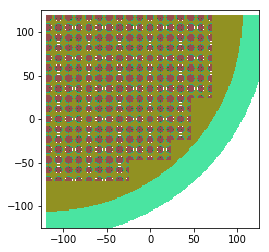

In [22]:
root2_uni.plot(width=(250.0, 250.0), color_by = 'material', origin=(0, 0, 0))

In [23]:
geom = openmc.Geometry(root2_uni)
geom.export_to_xml()
!cat geometry.xml

<?xml version='1.0' encoding='utf-8'?>
<geometry>
    <cell id="10000" material="1" region="-10000" universe="10000" />
    <cell id="10001" material="void" region="10000 -10001" universe="10000" />
    <cell id="10002" material="2" region="10001 -10002" universe="10000" />
    <cell id="10003" material="3" region="10002 10003 -10004 10005 -10006" universe="10000" />
    <cell id="10004" material="4" region="-10007" universe="10001" />
    <cell id="10005" material="void" region="10007 -10008" universe="10001" />
    <cell id="10006" material="2" region="10008 -10009" universe="10001" />
    <cell id="10007" material="3" region="10009 10010 -10011 10012 -10013" universe="10001" />
    <cell fill="10002" id="10008" region="10014 -10015 10016 -10017" universe="10003" />
    <cell id="10009" material="3" region="10018 -10019 10020 -10021" universe="10004" />
    <cell fill="10005" id="10010" region="-10022 10024 -10025" universe="10006" />
    <cell id="10011" material="5" region="10022 -

In [24]:
#Defining starting sources (Using the stats.Box term to make a 2D box with only fissionable sources accepted)
space_src = openmc.stats.Box([-(15*17*pitch/2), -(15*17*pitch/2), -10], [15*17*pitch/2, 15*17*pitch/2, 10], only_fissionable=True)

source = openmc.Source(space=space_src)

In [25]:
#Adding Sources to Settings 
settings = openmc.Settings()
settings.source = [source]

settings.batches = 10
settings.inactive = 2
settings.particles = 100000

#Export Settings to xml
settings.export_to_xml()
!cat settings.xml

<?xml version='1.0' encoding='utf-8'?>
<settings>
    <run_mode>eigenvalue</run_mode>
    <particles>100000</particles>
    <batches>10</batches>
    <inactive>2</inactive>
    <source strength="1.0">
        <space type="fission">
            <parameters>-178.5 -178.5 -10 178.5 178.5 10</parameters>
        </space>
    </source>
</settings>


In [26]:
#Tallies
mesh = openmc.Mesh()
mesh.type = 'regular'
mesh.dimension = [300,300]
mesh.lower_left = [-150, -150]
mesh.upper_right = [150, 150]
mesh_filter = openmc.MeshFilter(mesh)

thermal_filter = openmc.EnergyFilter([0., 0.625])
fast_filter = openmc.EnergyFilter([0.625, 20.0e6])

#reflector_mesh = openmc.CMFDMesh()
#reflector_mesh.dimension = [200, 200]
#reflector_mesh.lower_left = [-120, -120]
#reflector_mesh.upper_right = [120, 120]
#reflector_mesh.energy = [0, 0.625, 20.0e6]
#reflector_filter = openmc.MeshFilter(reflector_mesh)

t1 = openmc.Tally(name = 'Reactor Core Thermal Flux')
t1.filters = [mesh_filter, thermal_filter]
t1.scores = ['flux']

t2 = openmc.Tally(name = 'Reactor Core Fast Flux')
t2.filters = [mesh_filter, fast_filter]
t2.scores = ['flux']

t3 = openmc.Tally(name = 'Reactor Core Thermal Flux with CMFD')
t3.filters = [mesh_filter, thermal_filter]
#t3.filters.append(reflector_filter)
t3.scores = ['flux']

t4 = openmc.Tally(name = 'Reactor Core Fast Flux with CMFD')
t4.filters = [mesh_filter, fast_filter]
#t4.filters.append(reflector_filter)
t4.scores = ['flux']

reflector_thermal_flux = openmc.CellFilter(reflector_cell2)
t5 = openmc.Tally(name = 'Reflector Thermal Flux with CMFD')
t5.filters.append(mesh_filter)
t5.filters.append(thermal_filter)
#t5.filters.append(reflector_filter)
t5.filters.append(reflector_thermal_flux)
t5.scores = ['flux']

reflector_thermal_flux = openmc.CellFilter(reflector_cell2)
t6 = openmc.Tally(name = 'Reflector Thermal Flux only CMFD')
t6.filters.append(thermal_filter)
#t6.filters.append(reflector_filter)
t6.filters.append(reflector_thermal_flux)
t6.scores = ['flux']

reflector_fast_flux = openmc.CellFilter(reflector_cell2)
t7 = openmc.Tally(name = 'Reflector Fast Flux with CMFD')
t7.filters.append(mesh_filter)
t7.filters.append(fast_filter)
#t7.filters.append(reflector_filter)
t7.filters.append(reflector_fast_flux)
t7.scores = ['flux']

reflector_fast_flux = openmc.CellFilter(reflector_cell2)
t8 = openmc.Tally(name = 'Reflector Fast Flux only CMFD')
t8.filters.append(fast_filter)
#t8.filters.append(reflector_filter)
t8.filters.append(reflector_fast_flux)
t8.scores = ['flux']

reflector_current = openmc.CellFilter(reflector_cell2)
t9 = openmc.Tally(name = 'Reflector Thermal Current with CMFD')
t9.filters.append(mesh_filter)
t9.filters.append(thermal_filter)
#t9.filters.append(reflector_filter)
t9.filters.append(reflector_current)
t9.scores = ['current']

#inner_reflector_current = openmc.SurfaceFilter(bins = reflector_inner)
#t15 = openmc.Tally(nane = 'Reflector Inner Current')
#t15.filters.append(mesh_filter)
#t15.filters.append(inner_reflector_current)
#t15.scores = ['currnet']

#reflector_current = openmc.CellFilter(reflector_cell2)
#t10 = openmc.Tally(name = 'Reflector Thermal Current only CMFD')
#t10.filters.append(thermal_filter)
#t10.filters.append(reflector_filter)
#t10.filters.append(reflector_current)
#t10.scores = ['current']

reflector_current = openmc.CellFilter(reflector_cell2)
t11 = openmc.Tally(name = 'Reflector Fast Current with CMFD')
t11.filters.append(mesh_filter)
t11.filters.append(fast_filter)
#t11.filters.append(reflector_filter)
t11.filters.append(reflector_current)
t11.scores = ['current']

#reflector_current = openmc.CellFilter(reflector_cell2)
#t12 = openmc.Tally(name = 'Reflector Fast Current only CMFD')
#t12.filters.append(fast_filter)
#t12.filters.append(reflector_filter)
#t12.filters.append(reflector_current)
#t12.scores = ['current']

t13 = openmc.Tally(name='Carbon Scattering Rate')
t13.filters = [openmc.CellFilter(reflector_cell2)]
t13.scores = ['scatter']

t14 = openmc.Tally(name='Carbon Absorption Rate')
t14.filters = [openmc.CellFilter(reflector_cell2)]
t14.scores = ['absorption']

vacuum_current = openmc.CellFilter(vacuum_cell)
#vacuum_current2 = openmc.arithmetic.AggregateFilter(aggregate_filter=vacuum_current, aggregate_op='avg')
#vacuum_current2.aggregate_filter=mesh_filter
#vacuum_current2.aggregate_op='avg'
t15 = openmc.Tally(name = 'Vacuum Current')
t15.filters.append(mesh_filter)
t15.filters.append(vacuum_current)
t15.scores = ['current']

#print([t1, t2, t3, t4, t5, t6, t7, t8, t9, t10, t11, t12, t13, t14])
tallies = openmc.Tallies([t1, t2, t3, t4, t5, t6, t7, t8, t9, t11, t13, t14, t15])
tallies.export_to_xml()
!cat tallies.xml

<?xml version='1.0' encoding='utf-8'?>
<tallies>
    <mesh id="10000" type="regular">
        <dimension>300 300</dimension>
        <lower_left>-150 -150</lower_left>
        <upper_right>150 150</upper_right>
    </mesh>
    <tally id="10000" name="Reactor Core Thermal Flux">
        <filter bins="10000" type="mesh" />
        <filter bins="0.0 0.625" type="energy" />
        <scores>flux</scores>
    </tally>
    <tally id="10001" name="Reactor Core Fast Flux">
        <filter bins="10000" type="mesh" />
        <filter bins="0.625 20000000.0" type="energy" />
        <scores>flux</scores>
    </tally>
    <tally id="10002" name="Reactor Core Thermal Flux with CMFD">
        <filter bins="10000" type="mesh" />
        <filter bins="0.0 0.625" type="energy" />
        <scores>flux</scores>
    </tally>
    <tally id="10003" name="Reactor Core Fast Flux with CMFD">
        <filter bins="10000" type="mesh" />
        <filter bins="0.625 20000000.0" type="energy" />
        <scores>flux

In [27]:
openmc.run()


                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               #######################     %%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%

0

In [28]:
sp = openmc.StatePoint('statepoint.10.h5')

In [29]:
scatter = sp.get_tally(name='Carbon Scattering Rate')
absorption = sp.get_tally(name='Carbon Absorption Rate')

scatter.get_pandas_dataframe()

cell nuclide    score     mean  std. dev.
0  10011   total  scatter 1.87e-01   1.68e-02

In [30]:
absorption.get_pandas_dataframe()

cell nuclide       score     mean  std. dev.
0  10011   total  absorption 2.51e-04   2.16e-05

In [31]:
ratio = scatter / absorption
ratio.get_pandas_dataframe()

cell nuclide                   score     mean  std. dev.
0  10011   total  (scatter / absorption) 7.43e+02   9.26e+01

In [32]:
MR = 0.158 * ratio
MR.get_pandas_dataframe()

print('Modertor Ratio:')
mean_MR = float(MR.mean)
std_MR = float(MR.std_dev)
print(mean_MR, '+/-', std_MR)

Modertor Ratio:
117.33403578272066 +/- 14.632200678102654


In [33]:
Reactor_Core_Thermal_Flux = sp.get_tally(name='Reactor Core Thermal Flux')
Reactor_Core_Fast_Flux = sp.get_tally(name='Reactor Core Fast Flux')
Reflector_Thermal_Flux = sp.get_tally(name='Reflector Thermal Flux with CMFD')
Reflector_Fast_Flux = sp.get_tally(name='Reflector Fast Flux with CMFD')
Reflector_Thermal_Current = sp.get_tally(name='Reflector Thermal Current with CMFD')
Reflector_Fast_Current = sp.get_tally(name='Reflector Fast Current with CMFD')
Vacuum_Current = sp.get_tally(name='Vacuum Current')

In [34]:
#leak = Vacuum_Current.summation(filter_type=openmc.SurfaceFilter, remove_filter=True)
#leak = Vacuum_Current.summation(filter_type=openmc.MeshFilter, remove_filter=True)
#leak.get_pandas_dataframe()

leak = Vacuum_Current.summation(filter_type=openmc.CellFilter, remove_filter=True)
leak = Vacuum_Current.summation(filter_type=openmc.MeshFilter, remove_filter=True)
#leak = Vacuum_Current.summation(filter_type=openmc.filter, remove_filter=True)
leak.get_pandas_dataframe()

cell    surface nuclide    score     mean  std. dev.
0  10012  x-min out   total  current 8.39e+00   3.52e-03
1  10012   x-min in   total  current 8.65e+00   3.59e-03
2  10012  x-max out   total  current 8.65e+00   3.59e-03
3  10012   x-max in   total  current 8.39e+00   3.52e-03
4  10012  y-min out   total  current 8.65e+00   3.59e-03
5  10012   y-min in   total  current 8.40e+00   3.54e-03
6  10012  y-max out   total  current 8.40e+00   3.54e-03
7  10012   y-max in   total  current 8.65e+00   3.59e-03

In [35]:
print(Reactor_Core_Thermal_Flux.mean.shape)
print(Reactor_Core_Fast_Flux.mean.shape)
print(Reflector_Thermal_Flux.mean.shape)
print(Reflector_Fast_Flux.mean.shape)
print(Reflector_Thermal_Current.mean.shape)
print(Reflector_Fast_Current.mean.shape)

(90000, 1, 1)
(90000, 1, 1)
(90000, 1, 1)
(90000, 1, 1)
(720000, 1, 1)
(720000, 1, 1)


Reactor Core Thermal Flux:


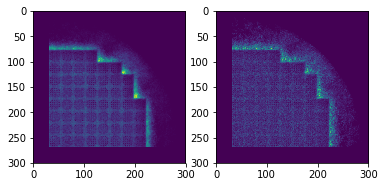

In [36]:
%matplotlib inline
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt

Reactor_Core_Thermal_Flux.std_dev.shape = (300, 300)
Reactor_Core_Thermal_Flux.mean.shape = (300, 300)

print('Reactor Core Thermal Flux:')
fig = plt.subplot(121)

fig.imshow(Reactor_Core_Thermal_Flux.mean)

fig2 = plt.subplot(122)
fig2.imshow(Reactor_Core_Thermal_Flux.std_dev)

Reactor Core Fast Flux:


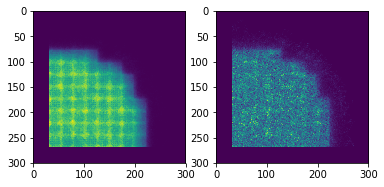

In [37]:
Reactor_Core_Fast_Flux.std_dev.shape = (300, 300)
Reactor_Core_Fast_Flux.mean.shape = (300, 300)

print('Reactor Core Fast Flux:')
fig = plt.subplot(121)
fig.imshow(Reactor_Core_Fast_Flux.mean)
fig2 = plt.subplot(122)
fig2.imshow(Reactor_Core_Fast_Flux.std_dev)

Reflector Thermal Flux:


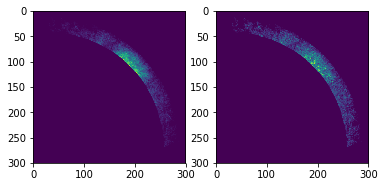

In [38]:
Reflector_Thermal_Flux.std_dev.shape = (300, 300)
Reflector_Thermal_Flux.mean.shape = (300, 300)

print('Reflector Thermal Flux:')
fig = plt.subplot(121)

fig.imshow(Reflector_Thermal_Flux.mean)
#fig.set_xlim(100, 150)
#fig.set_ylim(40, 60)
#fig.show()
fig2 = plt.subplot(122)
fig2.imshow(Reflector_Thermal_Flux.std_dev)

In [ ]:
RTF = Reflector_Thermal_Flux.get_pandas_dataframe()

In [ ]:
Reflector_T_Flux = RTF[RTF['score'] == 'flux']
print(Reflector_T_Flux[['mean', 'std. dev.']].dropna().describe())
RTF2 = Reflector_T_Flux.dropna()

In [ ]:
print(RTF2)

In [ ]:

leak = RTF.summation(filter_type=openmc.SurfaceFilter, remove_filter=True)
leak = RTF.summation(filter_type=openmc.MeshFilter, remove_filter=True)

In [ ]:
Reflector_Thermal_Current.std_dev.shape = (400, 800)
Reflector_Thermal_Current.mean.shape = (400, 800)

print('Reflector Thermal Current:')
fig = plt.subplot(121)
fig.imshow(Reflector_Thermal_Current.mean)
fig2 = plt.subplot(122)
fig2.imshow(Reflector_Thermal_Current.std_dev)

In [ ]:
fig3 = plt.plot(flux.mean)
plt.ylabel('flux mean')
plt.show()

In [ ]:
fig4 = plt.plot(flux.std_dev)
plt.ylabel('flux std_dev')
plt.show()

In [ ]:
tally2 = sp.get_tally(scores=['current'])
current = tally2.get_slice(scores=['current'])
print(current)

current.std_dev.shape = (100, 100)
current.mean.shape = (100, 100)

fig3 = plt.subplot(121)
fig3.imshow(current.mean)
fig4 = plt.subplot(122)
fig4.imshow(current.std_dev)

In [ ]:
tally2.mean.shape

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import openmc.model

%matplotlib inline
! rm -f *.h5 *.xml

In [2]:
# Create the model. `fuel_enritchment` will be the parametric variable.

def build_model(fuel_enritchment):
    # Create the lattice materials
    uo2 = openmc.Material(1, "uo2")
    uo2.add_element('U', 1.0, enrichment=fuel_enritchment)
    uo2.add_element('O', 2.0)
    uo2.set_density('g/cm3', 10.7)
    
    zirconium = openmc.Material(2, "zirconium")
    zirconium.add_element('Zr', 1.0)
    zirconium.set_density('g/cm3', 6.6)
    
    water = openmc.Material(3, 'h2o')
    water.add_element('H', 2.0)
    water.add_element('O', 1.0)
    water.set_density('g/cm3', 1.0)
    water.add_s_alpha_beta('c_H_in_H2O')
    
    boroncarbide = openmc.Material(4, "b4c")
    boroncarbide.add_element('B', 4.0)
    boroncarbide.add_element('C', 1.0)
    boroncarbide.set_density('g/cm3', 2.52)
    
    beryllium = openmc.Material(5, 'Be')
    beryllium.add_element('Be', 1.0)
    beryllium.set_density('g/cm3', 1.85)
    
    # Create a Materials object
    materials = openmc.Materials([uo2, zirconium, water, boroncarbide, beryllium])
    
    # Create cylinders for the fuel
    R_fuel = 0.96/2
    R_inner_clad = 0.98/2
    R_outer_clad = 1.12/2
    pitch = 1.4
    
    #Fuel Pin Surfaces
    fuel_or = openmc.ZCylinder(R=R_fuel)
    fuel_clad_ir = openmc.ZCylinder(R=R_inner_clad)
    fuel_clad_or = openmc.ZCylinder(R=R_outer_clad)
    fuel_box_surface = openmc.get_rectangular_prism(width=pitch, height=pitch)

    #Fuel Pin Region
    fuel_region = -fuel_or
    fuel_gap_region = +fuel_or & -fuel_clad_ir
    fuel_clad_region = +fuel_clad_ir & -fuel_clad_or
    fuel_water_region = +fuel_clad_or & fuel_box_surface

    #Fuel Pin Cell
    fuel_lattice = openmc.Cell(fill=uo2, region=fuel_region)
    fuel_gap_lattice = openmc.Cell(region=fuel_gap_region)
    fuel_clad_lattice = openmc.Cell(fill=zirconium, region=fuel_clad_region)
    fuel_moderator_lattice = openmc.Cell(fill=water, region=fuel_water_region)

    #Fuel Pin Universe
    fuel_uni = openmc.Universe(cells=(fuel_lattice, fuel_gap_lattice, fuel_clad_lattice, fuel_moderator_lattice))
    
    #Control Pin Surfaces 
    control_or = openmc.ZCylinder(R=R_fuel)
    control_clad_ir = openmc.ZCylinder(R=R_inner_clad)
    control_clad_or = openmc.ZCylinder(R=R_outer_clad)
    control_box_surface = openmc.get_rectangular_prism(width=pitch, height=pitch)

    #Control Pin Region 
    control_region = -control_or
    control_gap_region = +control_or & -control_clad_ir
    control_clad_region = +control_clad_ir & -control_clad_or
    control_water_region = +control_clad_or & control_box_surface

    #Control Pin Cell 
    control_lattice = openmc.Cell(fill=boroncarbide, region=control_region)
    control_gap_lattice = openmc.Cell(region=control_gap_region)
    control_clad_lattice = openmc.Cell(fill=zirconium, region=control_clad_region)
    control_moderator_lattice = openmc.Cell(fill=water, region=control_water_region)

    #Control Pin Universe
    control_universe = openmc.Universe(cells=(control_lattice, control_gap_lattice, control_clad_lattice, control_moderator_lattice))

    #Define the Lattice
    lat = openmc.RectLattice()
    lat.pitch = [pitch, pitch]
    lat.lower_left = (-(17*pitch/2), -(17*pitch/2))
    
    #Creating array indices for control rod locations in latice (Lower Left is 0,0)
    template_x = np.array([5, 8, 11, 3, 13, 2, 5, 8, 11, 14, 2, 5, 8, 
                           11, 14, 2, 5, 8, 11, 14, 3, 13, 5, 8, 11])
    template_y = np.array([2, 2, 2, 3, 3, 5, 5, 5, 5, 5, 8, 8, 8, 8, 
                           8, 11, 11, 11, 11, 11, 13, 13, 14, 14, 14])
    
    #Add Universes to Lattice
    lat.universes = np.tile(fuel_uni, (17, 17)) 
    lat.universes[template_x, template_y] = control_universe 
    
    #Define Cell for Lattice as a Single Unit (Region of entire lattice)
    lattice_region = openmc.get_rectangular_prism(width=17*pitch, height=17*pitch)
    root_cell = openmc.Cell(fill=lat, region=lattice_region)
    
    #Definining Universe
    root_uni = openmc.Universe(name="root universe")
    root_uni.add_cell(root_cell)
    
    water_left_inner = openmc.XPlane(x0=-(17*pitch/2))
    water_right_inner = openmc.XPlane(x0=(17*pitch/2))
    water_bottom_inner = openmc.YPlane(y0=-(17*pitch/2))
    water_top_inner = openmc.YPlane(y0=(17*pitch/2))
    
    water_region = +water_left_inner & -water_right_inner & +water_bottom_inner & -water_top_inner
    water_cell = openmc.Cell(fill=water, region=water_region)
    water_universe = openmc.Universe(name='water_universe')
    water_universe.add_cell(water_cell)
    
    lat2 = openmc.RectLattice()
    lat2.pitch = [17*pitch, 17*pitch]
    lat2.lower_left = (-(10*17*pitch/2), -(10*17*pitch/2))

    fuel_template_x = np.array([0, 1, 2, 3, 4, 5, 6, 7, 
                                0, 1, 2, 3, 4, 5, 6, 7, 
                                0, 1, 2, 3, 4, 5, 6, 7, 
                                0, 1, 2, 3, 4, 5, 6, 7, 
                                0, 1, 2, 3, 4, 5, 6, 
                                0, 1, 2, 3, 4, 5, 6, 
                                0, 1, 2, 3, 4, 5, 
                                0, 1, 2, 3])
    fuel_template_y = np.array([0, 0, 0, 0, 0, 0, 0, 0, 
                                1, 1, 1, 1, 1, 1, 1, 1, 
                                2, 2, 2, 2, 2, 2, 2, 2, 
                                3, 3, 3, 3, 3, 3, 3, 3, 
                                4, 4, 4, 4, 4, 4, 4, 
                                5, 5, 5, 5, 5, 5, 5, 
                                6, 6, 6, 6, 6, 6, 
                                7, 7, 7, 7])
    water_template_x = np.array([0, 1, 2, 3, 4, 
                                 4, 5, 6, 
                                 6, 7, 
                                 7, 
                                 7, 8, 
                                 8, 
                                 8, 
                                 8, 
                                 8])
    water_template_y = np.array([8, 8, 8, 8, 8, 
                                 7, 7, 7, 
                                 6, 6, 
                                 5, 
                                 4, 4, 
                                 3, 
                                 2, 
                                 1, 
                                 0])
    lat2.universes = np.tile(water_universe, (10, 10))
    lat2.universes[fuel_template_x, fuel_template_y] = root_uni
    
    reactor_left_inner = openmc.XPlane(x0=-(10*17*pitch/2), boundary_type='reflective')
    reactor_top_inner = openmc.YPlane(y0=(10*17*pitch/2), boundary_type='reflective')

    R_inner_reflector = 225
    R_outer_reflector = 265

    reflector_inner = openmc.ZCylinder(R=R_inner_reflector, x0=-119, y0=119)
    reflector_outer = openmc.ZCylinder(R=R_outer_reflector, boundary_type='vacuum', x0=-119, y0=119)


    reactor_region = -reflector_inner & +reactor_left_inner & -reactor_top_inner
    reflector_region = +reflector_inner & -reflector_outer & +reactor_left_inner & -reactor_top_inner
    vacuum_region = +reflector_outer

    reactor_cell = openmc.Cell(fill=lat2, region=reactor_region)
    reflector_cell2 = openmc.Cell(fill=beryllium, region=reflector_region)
    vacuum_cell = openmc.Cell(region=vacuum_region)

    root2_uni = openmc.Universe(name='root2 universe', cells=(reactor_cell, reflector_cell2, vacuum_cell))

    geom = openmc.Geometry(root2_uni)
    
    #Defining starting sources (Using the stats.Box term to make a 2D box with only fissionable sources accepted)
    space_src = openmc.stats.Box([-(15*17*pitch/2), -(15*17*pitch/2), -10], [15*17*pitch/2, 15*17*pitch/2, 10], only_fissionable=True)
    source = openmc.Source(space=space_src)
    
    #Adding Sources to Settings 
    settings = openmc.Settings()
    settings.source = [source]
    settings.batches = 15
    settings.inactive = 5
    settings.particles = 100000
    settings.run_mode = 'eigenvalue'
        
    # We dont need a tallies file so dont waste the disk input/output time
    settings.output = {'tallies': False}
    
    model = openmc.model.Model(geom, materials, settings)
    
    return model

In [3]:
! rm -f *.h5 *.xml

In [4]:
#Perform the search
fuel_enritchment, guesses, keffs = openmc.search_for_keff(build_model, bracket=[2, 8],
                                                  tol=1.E-3, bracketed_method='bisect',
                                                  print_iterations=True)

print('Critical Fuel Enritchment: {:6.4f} % U-235'.format(fuel_enritchment))


Iteration: 1; Guess of 2.00e+00 produced a keff of 0.79004 +/- 0.00113


/home/jason/anaconda3/lib/python3.6/site-packages/openmc-0.9.0-py3.6-linux-x86_64.egg/openmc/material.py:620: UserWarning: A uranium enrichment of 8.0 was given for Material ID="1". OpenMC assumes the U234/U235 mass ratio is constant at 0.008, which is only valid at low enrichments. Consider setting the isotopic composition manually for enrichments over 5%.
  warnings.warn(msg)


Iteration: 2; Guess of 8.00e+00 produced a keff of 1.09002 +/- 0.00162
Iteration: 3; Guess of 5.00e+00 produced a keff of 1.00078 +/- 0.00101
Iteration: 4; Guess of 3.50e+00 produced a keff of 0.92471 +/- 0.00086
Iteration: 5; Guess of 4.25e+00 produced a keff of 0.96801 +/- 0.00130
Iteration: 6; Guess of 4.62e+00 produced a keff of 0.98220 +/- 0.00115
Iteration: 7; Guess of 4.81e+00 produced a keff of 0.99173 +/- 0.00081
Iteration: 8; Guess of 4.91e+00 produced a keff of 0.99755 +/- 0.00098
Iteration: 9; Guess of 4.95e+00 produced a keff of 0.99888 +/- 0.00106
Iteration: 10; Guess of 4.98e+00 produced a keff of 1.00024 +/- 0.00130
Iteration: 11; Guess of 4.96e+00 produced a keff of 0.99954 +/- 0.00174
Iteration: 12; Guess of 4.97e+00 produced a keff of 1.00001 +/- 0.00140
Iteration: 13; Guess of 4.97e+00 produced a keff of 0.99677 +/- 0.00126
Critical Fuel Enritchment: 4.9678 % U-235


In [ ]:
plt.figure(figsize=(8, 4.5))
plt.title('Eigenvalue versus Control Rod Radius')
# Create a scatter plot using the mean value of keff
plt.scatter(guesses, [keffs[i][0] for i in range(len(keffs))])
plt.xlabel('Control Rod Radius [cm]')
plt.ylabel('Eigenvalue')
plt.show()